# Finding prediction Power of COVID-19  Cases for deaths
Here we load two time series arrays - deaths and confirmed cases.  
We calculate the Pearson Coefficient between them as we shift Cases forward by days, to determine the predictive range of Cases for Deaths.

In [1]:
import datetime
from os.path import dirname, join
import os
import numpy as np
import pandas as pd
import pdb

import matplotlib.pyplot as plt
from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

## Download the COVID-9 Data from JHU Repository

In [2]:
!pip install wget
!python collectdata.py

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=3eea91dea849a37a13032dd06476d5d8fb7adab66fdf08dbd0c3b863c65d5b6b
  Stored in directory: /home/jovyan/.cache/pip/wheels/90/1d/93/c863ee832230df5cfc25ca497b3e88e0ee3ea9e44adc46ac62
Successfully built wget
processing time_series_covid19_deaths_US.csv
100% [......................................................] 1998413 / 1998413processing time_series_covid19_confirmed_US.csv
100% [......................................................] 2507437 / 2507437

## Load the Cases and Deaths csv files into Panda Data Frames

In [3]:
# Load the panda dataframes
df_cc = pd.read_csv('covid-confirmed.tsv', delimiter='\t') 
df_d = pd.read_csv('covid-deaths.tsv', delimiter='\t') 
#list(df_d.columns)
df_d.head()

,date,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,20200122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20200123,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20200124,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20200125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20200126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Quick Plot of cases and deaths
mystate = 'Massachusetts'
# tick every 7 day
rule = rrulewrapper(DAILY, interval=30)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')
dates = pd.to_datetime(df_d.date, format='%Y%m%d')
y = df_d[mystate]

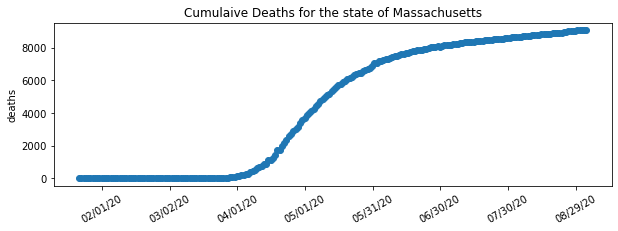

In [5]:
fig, ax = plt.subplots(figsize=(10,3))
plt.plot_date(dates, y, label='Cumulative Deaths')
ax.set_ylabel('deaths')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
plt.title('Cumulaive Deaths for the state of ' + mystate)
plt.show()

In [6]:
# We want to predict the daily death count based on daily covis-19 case counts 
state = 'Massachusetts'
s_cc = df_cc[state].diff()
s_cc[s_cc < 0] = 0
s_d = df_d[state].diff()
s_d[s_d < 0] = 0
s_d= s_d.fillna(0)
s_d

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
221    13.0
222    11.0
223     4.0
224     0.0
225    17.0
Name: Massachusetts, Length: 226, dtype: float64

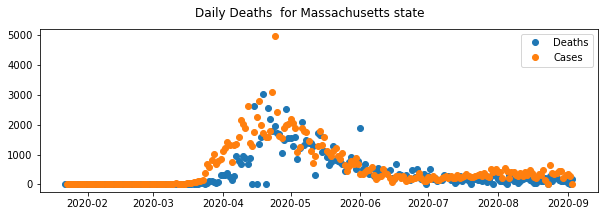

In [7]:
fig= plt.figure(figsize=(10,3))
fig.suptitle('Daily Deaths  for ' + state + ' state')
plt.plot_date(dates, s_d * 10, label = 'Deaths')  # multiple deaths by 10 for visual clarity
plt.plot_date(dates, s_cc, label= 'Cases')
plt.legend()
plt.show()

## Create a graph of value of Pearson Co-efficient as a function of shift in Cases
This is to find how many days forward does Cases best predict Deaths

In [9]:

ar_offset = []
ar_psn_r =[]
best_doffset = 0 # assume in synch
psn_best = -1    # assume pefectly inverted 
for doffset in range(30):
    ar_offset.append(doffset) 
    s_cc_o = s_cc.shift(periods = doffset, fill_value=0)  # shift Cases forward by doffset days, putting 0's in new slots
    psn_r = s_d.corr(s_cc_o) # Calculate Pearson corelation
    if psn_r > psn_best:
        psn_best = psn_r
        best_doffset = doffset
    ar_psn_r.append(psn_r) 
    #print('With ', doffset, ' day shift', psn_r)
dates = pd.to_datetime(df_cc.date, format='%Y%m%d')
predict = pd.DataFrame()
predict["Day Offset"] = ar_offset
predict["Pearson r"] = ar_psn_r
predict.head()
str_rsnbest = "{:5.2f}".format(psn_best)
str_title = f'Pearsons r vs offset to Cases for the state of {state} (max of {str_rsnbest} at {best_doffset} day offset)'
print (f'Highest Pearson Correlation value of {str_rsnbest} occurs when Cases shifted forward {best_doffset} days')

Highest Pearson Correlation value of  0.82 occurs when Cases shifted forward 7 days


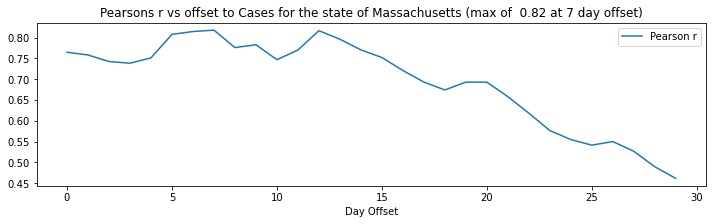

In [10]:
predict.plot(kind='line', x='Day Offset',    y='Pearson r', figsize=(12,3), title = str_title )
plt.show()